**STEP 0: SETUP**
*   Setup the environment here.
*   Install/Import libraries as needed.
*   Mount drive(s)


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from __future__ import absolute_import, division, print_function
import pathlib
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import pandas as pd
import matplotlib as plt
from matplotlib import pyplot  as plt
from google.colab import files
print(tf.__version__)

2.15.0


In [ ]:
#!pip install torch

In [ ]:
import yfinance as yf

In [ ]:
!pip install pandas-ta
import pandas_ta as pta

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.1/115.1 kB 1.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pandas-ta: filename=pandas_ta-0.3.14b0-py3-none-any.whl size=218907 sha256=ec3770af382ac69f27d0c7e87177148f3ed2ea34ce0a8cf74d23f09f864bc289
  Stored in directory: /root/.cache/pip/wheels/69/00/ac/f7fa862c34b0e2ef320175100c233377b4c558944f12474cf0
Successfully built pandas-ta


In [ ]:
!pip install ta
import ta
from ta.momentum import RSIIndicator
from ta.momentum import StochasticOscillator
from ta.trend import ADXIndicator
from ta.volatility import BollingerBands
from ta.volatility import AverageTrueRange

  Preparing metadata (setup.py) ... done
  Created wheel for ta: filename=ta-0.11.0-py3-none-any.whl size=29411 sha256=ff436b71adaf3f65fd0332d66b073e654d9884860a80838a2f4b1a673263d282
  Stored in directory: /root/.cache/pip/wheels/5f/67/4f/8a9f252836e053e532c6587a3230bc72a4deb16b03a829610b
Successfully built ta


In [ ]:
import warnings
warnings.filterwarnings('ignore')


**STEP 1: PREPROCESSING**
*   Fetch Data and process it to derive more data
*   Cleanup the data to make it ready for the next step


In [ ]:
tkr = 'INDUSINDBK.NS'
#tkr = 'HDFCBANK.NS'
data = yf.download(tkr, start='2022-05-01', end='2024-12-31')

#Adjust High, Low, Open Close prices.
data['Open'] = data['Open']*data['Adj Close']/data['Close']
data['High'] = data['High']*data['Adj Close']/data['Close']
data['Low'] = data['Low']*data['Adj Close']/data['Close']
data['Close'] = data['Adj Close']

[*********************100%%**********************]  1 of 1 completed


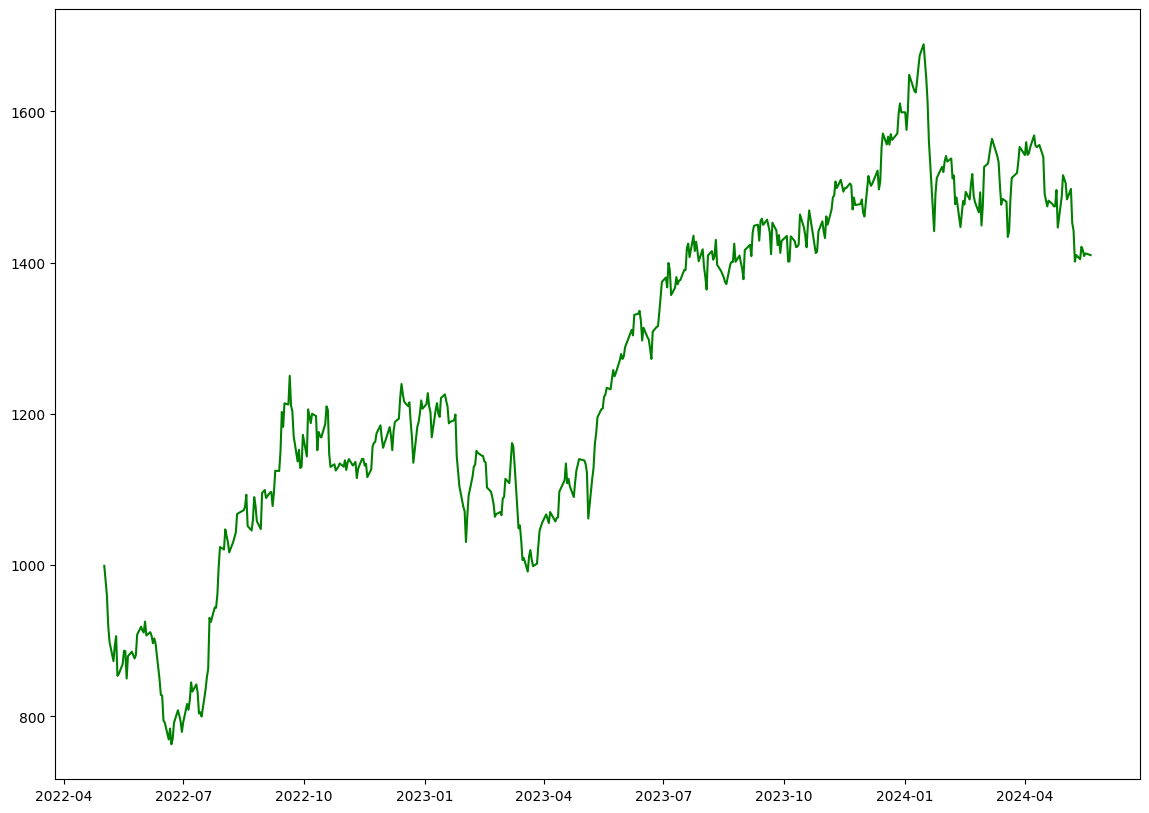

In [ ]:
#plt.subplot(3,1,1)
plt.figure(figsize=(14, 10))
plt.plot(data['Close'], color='g')


In [ ]:
plt.subplot(4,1,1)
#plt.plot(data['sig-buy'], color='b')
plt.plot(data['pta-adx-pn%'][:200], color='b')

plt.subplot(4,1,2)
plt.plot(data['pta-rsi'][:200], color='k')

plt.subplot(4,1,3)
plt.plot(data['Adj Close'][:200], color='k')
adj_rsi = 20*(1 + data['pta-adx-pn%'])/data['pta-rsi']
plt.subplot(4,1,4)
plt.plot(adj_rsi[:200], color='k')

In [ ]:
#MACD uisng TA Pkg
macd_obj = ta.trend.MACD(data['Adj Close'])
data['ta-macd'] = macd_obj.macd()
data['ta-macd-sig'] = macd_obj.macd_signal()
data['ta-macd-sig%'] = data['ta-macd']/data['ta-macd-sig']

#RSI using Pandas TA package
df1 = pta.rsi(data['Adj Close'])
df1.rename('pta-rsi', inplace=True)
data = pd.concat([data, df1], axis=1)
#data['pta-rsi%-25'] = data['pta-rsi']/25.0

#Stoch indicator using Pandas TA pkg
df = pta.stoch(data['High'],data['Low'],data['Close'])
df.rename(columns={'STOCHk_14_3_3':'pta-stochk','STOCHd_14_3_3':'pta-stochd'}, inplace=True)
data = pd.concat([data, df], axis=1)

#Stochastic Oscillator using TA pkg
stoch = StochasticOscillator(data['High'],data['Low'],data['Close'])
data['ta-stoch'] = stoch.stoch()

df = pta.vwap(data['High'],data['Low'],data['Close'], data['Volume'])
df.rename('pta-vwap', inplace=True)
data = pd.concat([data, df], axis=1)


#ADX using Pandas TA pkg
df = pta.adx(data['High'],data['Low'],data['Close'])
df.rename(columns={'ADX_14':'pta-adx','DMP_14':'pta-adx-dmp','DMN_14':'pta-adx-dmn'}, inplace=True)
data = pd.concat([data, df], axis=1)

#data['pta-adx%-25'] = data['pta-adx']/25
data['pta-adx-pn%'] = data['pta-adx-dmp']/data['pta-adx-dmn']

data['sma5'] = data['Adj Close'].rolling(5).mean()
data['sma10'] = data['Adj Close'].rolling(10).mean()
data['sma20'] = data['Adj Close'].rolling(20).mean()
data['sma50'] = data['Adj Close'].rolling(50).mean()
#data['sma200'] = data['Adj Close'].rolling(200).mean()
data['ema20'] = data['Adj Close'].ewm(span=20).mean()
#data['ema200'] = data['Adj Close'].ewm(span=200).mean()

data['sma5%'] =  data['Adj Close']/data['sma5']
data['sma10%'] =  data['Adj Close']/data['sma10']
data['sma20%'] =  data['Adj Close']/data['sma20']
data['sma50%'] =  data['Adj Close']/data['sma50']

data.dropna(inplace=True)


In [ ]:
#Calculate 'Up from 52 wk low' and 'down from 52 wk high'
def updn(df, period=50):
  max = df['Adj Close'].rolling(window=period).max().shift(1)
  min = df['Adj Close'].rolling(window=period).min().shift(1)
  dn = 1 - (df['Adj Close']/max)
  up = (df['Adj Close']/min) - 1
  return dn, up

data['dn50'], data['up50'] = updn(data)
#data

In [ ]:
# Function to get the invest values as some series crosses 1. Ex: MACD/Sig, SMA/Price ratios.
#This is done to allocate max points to the point where these series invert (important signals for buy/sell)
def conv_val(df):
  #df1 = pd.Series('buy-macd-sig')
  for i, v in df.items():
    if v > 1.:
      df[i] = 1/v;
  return df

In [ ]:
#data

In [ ]:
#adx discount factor
adx_disc = 0.1
#macd disc factor
macd_disc = 0.01

rsi = data['pta-rsi']/100.   # RSI value should be less than 25. Lesser the better
rsi = rsi.apply(lambda x: 0.01 if x > 0.45 else x)  #set RSI to zero for all RSI > 45 for buying
data.insert(1,'buy-rsi', rsi)

stochd = data['pta-stochd']/100.
stochd = stochd.apply(lambda x: 0.01 if x > 0.35 else x)  #set STOCHD to zero for all STOCHD > 35 for buying
data.insert(2,'buy-stochd', stochd)
data['buy-macd'] = data.apply(lambda row: 1. if row['ta-macd'] < 0. and row['ta-macd-sig'] < 0.  else 0, axis=1)
macd_sig = conv_val(data['ta-macd-sig%'].copy())
data.insert(3,'buy-macd-sig', macd_sig)
adx_pn= adx_disc*2/data['pta-adx-pn%']
data.insert(4,'buy-adx-pn', adx_pn)
data['buy-adx'] = adx_disc*10./data['pta-adx']
sma5 = conv_val(data['sma5%'].copy())
data.insert(5,'buy-sma5', sma5)
sma10 = conv_val(data['sma10%'].copy())
data.insert(6,'buy-sma10', sma10)
data['buy-sma50'] = data.apply(lambda row: 1. if row['sma50%'] < 0.99 else 0, axis=1)
sig = data[data.columns[data.columns.str.startswith('buy-')]].mul(data['buy-macd'], axis=0)
sig = sig.mul(data['buy-sma50'], axis=0)
sig = sig.drop(['buy-sma50', 'buy-macd'], axis = 1)
sig['signal-buy'] = sig.mean(axis=1)
data.insert(1,'sig-buy', sig['signal-buy'])
data = data.drop(['buy-macd', 'buy-sma50'], axis = 1)

In [ ]:
#adx discount factor
adx_disc = 0.1
#macd disc factor
macd_disc = 0.01

sell_rsi= data['pta-rsi']/100.   # RSI value should be greater than 70. More the better
sell_rsi = sell_rsi.apply(lambda x: 0.01 if x < 0.55 else x)  #set RSI to zero for all RSI < 55 for buying
data.insert(8,'sell-rsi', sell_rsi)
sell_stochd = data['pta-stochd']/100.
sell_stochd = sell_stochd.apply(lambda x: 0.01 if x < 0.65 else x)  #set STOCHD to zero for all STOCHD < 65 for buying
data.insert(9,'sell-stochd', sell_stochd)
data['sell-macd'] = data.apply(lambda row: 1. if row['ta-macd'] > 0. and row['ta-macd-sig'] > 0. else 0, axis=1)
macd_sig = conv_val(data['ta-macd-sig%'].copy())
data.insert(10,'sell-macd-sig', macd_sig)
adx_pn = 2*data['pta-adx-pn%']*adx_disc
data.insert(11,'sell-adx-pn',adx_pn)
data['sell-adx'] = adx_disc*10./data['pta-adx']
sma5 = conv_val(data['sma5%'].copy())
data.insert(12,'sell-sma5', sma5)

sma10 = conv_val(data['sma10%'].copy())
data.insert(13,'sell-sma10', sma10)
data['sell-sma50'] = data.apply(lambda row: 1. if row['sma50%'] > 1.01 else 0, axis=1)
data.describe()
sig1 = data[data.columns[data.columns.str.startswith('sell-')]].mul(data['sell-macd'], axis=0)
sig1 = sig1.mul(data['sell-sma50'], axis=0)
sig1 = sig1.drop(['sell-sma50', 'sell-macd'], axis = 1)
sig1['signal-sell'] = sig1.mean(axis=1)
data.insert(1,'sig-sell', sig1['signal-sell'])
data = data.drop(['sell-macd', 'sell-sma50'], axis = 1)


In [ ]:
data = data.drop(['Adj Close','Volume'], axis = 1)
data.dropna(inplace=True)
#data

In [ ]:
max = data['sig-buy'].max()
min = data['sig-buy'].min()
data['sig-buy'] = (data['sig-buy'] - min)/(max-min)

max = data['sig-sell'].max()
min = data['sig-sell'].min()
data['sig-sell'] = (data['sig-sell'] - min)/(max-min)

In [ ]:
data

In [ ]:
data.to_csv("drive/MyDrive/Colab Notebooks/TA_INDUSINDBANK-signals-CALCULATED-2.csv")

**STEP 4: BACKTESTING**

In [ ]:
def buy_sell_count(df, bcutoff, scutoff):
  buy_cnt = 0
  sell_cnt = 0
  if bcutoff <= 0. or bcutoff >= 1. or scutoff <= 0. or scutoff >= 1.:
    print("Cut off values must be between 0 and 1")
  else:
      buy_cnt = df[df['sig-buy'] >= bcutoff].count()
      sell_cnt = df[df['sig-sell'] >= scutoff].count()
      print(buy_cnt['sig-buy'], sell_cnt['sig-sell'])
  return buy_cnt['sig-buy'], sell_cnt['sig-buy']

In [ ]:
def build_trades(df, bcutoff, scutoff, units):
  # default buy/sell units is 1 for now.
  calls = ""
  trds = pd.DataFrame(columns=['entry_dt', 'entry_price','exit_dt', 'exit_price', 'rets'])
  buys = pd.DataFrame(columns=['edt', 'eprice'])
#loop through the dataframe and do the necessary calculations
  for index, row in df.iterrows():
    if row['sig-buy'] >= bcutoff:
      if buys.shape[0] < units:
        calls +='e,'
        buys = buys._append({'edt': index, 'eprice': row['Close']}, ignore_index = True)
    elif row['sig-sell'] >= scutoff:
      if not buys.empty:
        calls +='x,'
        trds = trds._append({'entry_dt': buys['edt'].iloc[0], 'entry_price': buys['eprice'].iloc[0], 'exit_dt': index, 'exit_price': row['Close'], 'rets': row['Close']/buys['eprice'].iloc[0]}, ignore_index = True)
        buys = buys.drop(buys.index[0])
    else:
      continue
  trds['profit_loss'] = (trds['rets'] - 1)*trds['entry_price']
  pl = trds['profit_loss'].copy()
  #trds
  pl.iloc[0] = pl.iloc[0] + trds['entry_price'].iloc[0]
  #trds['cum_amt'] += trds['entry_price'].iloc[0]
  trds['cum_amt'] = pl.cumsum()

  trds['cum_rets'] = trds['rets'].cumprod()
  return trds, calls
  #return trds


#trades = build_trades(data, buy_cutoff, sell_cutoff, units)

In [ ]:
def perf_metrics(df):
  metrics = {}
  total_profit = df['cum_amt'].iloc[-1] - df['entry_price'].iloc[0]
  perc_rets = (df['cum_rets'].iloc[-1] - 1)*100
  profit = 0.
  loss = 0.
  wins = 0
  for i, row in df.iterrows():
    if row['rets'] > 1.:
      profit += row['profit_loss']
      wins += 1
    elif row['rets'] < 1.:
      loss += (-1)*row['profit_loss']
    else:
      continue
  profit_factor = 0
  if loss > 0.:
    profit_factor = profit/loss
  else:
    profit_factor = pd.NA

  win_ratio = wins/df.shape[0]
  avg_profit = total_profit/df.shape[0]

  maxdd = df['cum_amt'].copy()
  #maxdd.insert(0, df['entry_price'].iloc[0])
  maxdd = pd.concat([pd.Series([df['entry_price'].iloc[0]]), maxdd])

  #mdd = df['profit_loss'].max() - df['cum_amt'].min()
  Roll_Max = maxdd.rolling(len(maxdd), min_periods=1).max()
  Daily_Drawdown = maxdd/Roll_Max - 1.0
  # Next we calculate the minimum (negative) daily drawdown in that window.
  # Again, use min_periods=1 if you want to allow the expanding window
  Max_Daily_Drawdown = Daily_Drawdown.rolling(len(maxdd), min_periods=1).min()
  mdd = Max_Daily_Drawdown.min()
  metrics = {'Total Profit' : total_profit, '% Rets': perc_rets,'Profit Factor': profit_factor,\
             'Win Ratio': win_ratio, 'Average Profit': avg_profit, 'Max Drawdown': mdd}

  return metrics, Roll_Max, Daily_Drawdown, Max_Daily_Drawdown

In [ ]:
# Run the Performance test

# Strategy: We have employed a very basic dumb strategy. That is to enter every entry call unless we exhaust
# the total number of investible units. Then we sell at the first sell call until we redeem all our investible units.
# It starts with first buy call. All sell calls before the first buy call are ignored.
# Any investments will be squared off on the last sell call

# Cut off values must be between 0 and 1. Units must be an integer and >= 1.
buy_cutoff = 0.55    #Cut off value for the signal to enter a trade. Lower values are ignored.
sell_cutoff = 0.55   # cut off for an exit.

units = 1          # no of investable units. This may be a parameter as the chances that there
                    # will be an alternate buy and sell signal are almost non-existent. Buy/sell signals happen is clusters

bcnt, scnt = buy_sell_count(data, buy_cutoff, sell_cutoff)
print("Buy Calls: ", bcnt)
print("Sell Calls: ", scnt)



99 211
Buy Calls:  99
Sell Calls:  211


In [ ]:
#build trades data
trades, calls = build_trades(data, buy_cutoff, sell_cutoff, units)
buyhold = data['Close'].iloc[-1]/data['Close'].iloc[0]   #Buy and Hold returns
#print("Average returns from custom signal" , trades['cum_rets'].iloc[-1]/trades.shape[0])
print("Buy and Hold returns" , buyhold)
print("calls" , calls)   # Print whether it is an entry('e') or exit('x') call

In [ ]:
trades

,entry_dt,entry_price,exit_dt,exit_price,rets,profit_loss,cum_amt,cum_rets
0,2022-11-07,1131.734375,2022-12-05,1182.527100,1.044880,50.792725,1182.527100,1.044880
1,2023-01-30,1077.232300,2023-04-20,1113.979004,1.034112,36.746704,1219.273804,1.080524
2,2024-02-02,1533.750000,2024-04-03,1542.650024,1.005803,8.900024,1228.173828,1.086794


In [ ]:
perf, rm, dd, mdd = perf_metrics(trades)

In [ ]:
perf

In [ ]:
mdd

**STEP 5: FINAL STEP**
*   Save data, files, script and model
*   

